In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
# !{sys.executable} -m pip install pmdarima
# import pmdarima as pm

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import collections
tf.enable_v2_behavior()

## Load Data

In [3]:
# df_prop = pd.read_csv("data/Denver-MLS/boston_property_info.csv")
df = pd.read_csv("../data/Denver-MLS/denver_listing_dates.csv")

In [344]:
df.zipcode = df.zipcode.astype("str")
df['list_month']=pd.to_datetime(df.list_date) + pd.offsets.MonthBegin(0)
df['sale_month']=pd.to_datetime(df.sale_date) + pd.offsets.MonthBegin(0)
display(df.head())

,property_id,zipcode,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,list_month,sale_month
0,482086548,80138,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,2016-03-01,2016-06-01
1,666680976,80113,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,2016-03-01,NaT
2,137981678,80241,2016-03-01,2016-04-21,NaN,NaN,NaN,Sale,320000.0,2016-03-01,2016-05-01
3,138763703,80228,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,333000.0,2016-03-01,2016-03-01
4,322015040,80108,2016-03-01,2016-06-09,NaN,NaN,NaN,Sale,611000.0,2016-03-01,2016-07-01


## EDA: Distribution per City, Zipcode

In [345]:
df_listing = df.groupby(["zipcode", "list_month"]).agg({"property_id":"count"}).reset_index()
df_listing = df_listing.rename(columns={"property_id":"count_listing"})

df_sale = df.groupby(["zipcode", "sale_month"]).agg({"property_id":"count", "sale_price":"sum"}).reset_index()
df_sale = df_sale.rename(columns={"property_id":"count_sale", "sale_price":"total_value"})

In [346]:
df_monthly = pd.merge(df_listing, df_sale, left_on = ['zipcode', 'list_month'], right_on = ['zipcode', 'sale_month'])
df_monthly = df_monthly.drop('list_month', axis=1)
df_monthly = df_monthly.rename(columns={'sale_month':'month'})
df_monthly.head()

,zipcode,count_listing,month,count_sale,total_value
0,80002,5,2016-03-01,2,647500.0
1,80002,40,2016-04-01,21,7822500.0
2,80002,29,2016-05-01,17,5915000.0
3,80002,47,2016-06-01,19,8517000.0
4,80002,42,2016-07-01,30,10230875.0


In [392]:
top10sales = list(df_monthly.groupby("zipcode").sum()['total_value'].sort_values(ascending=False).head(10).reset_index().zipcode)
top10unitSold = list(df_monthly.groupby("zipcode").sum()["count_sale"].sort_values(ascending=False).head(10).reset_index().zipcode)
top10listings = list(df_monthly.groupby("zipcode").sum()["count_listing"].sort_values(ascending=False).head(10).reset_index().zipcode)


### 1. Relationship with Population Density

In [373]:
# https://worldpopulationreview.com/zips/colorado
df_population = pd.read_csv("data/Denver-MLS/population_colorado.csv")
df_population['zip'] = df_population['zip'].astype(str)
df_monthly_population = pd.merge(df_monthly, df_population, left_on="zipcode", right_on="zip")
df_monthly_population = df_monthly_population[df_monthly_population['pop']>0]
df_monthly_population.drop("zip", axis=1, inplace=True)

In [374]:
df_monthly_population["count_listing_normalized"] = df_monthly_population["count_listing"]/df_monthly_population["pop"]
df_monthly_population["count_sale_normalized"] = df_monthly_population["count_sale"]/df_monthly_population["pop"]
df_monthly_population["total_value_normalized"] = df_monthly_population["total_value"]/df_monthly_population["pop"]
df_monthly_population.head()

,zipcode,count_listing,month,count_sale,total_value,city,county,pop,count_listing_normalized,count_sale_normalized,total_value_normalized
0,80002,5,2016-03-01,2,647500.0,Arvada,Jefferson,18266,0.000274,0.000109,35.448374
1,80002,40,2016-04-01,21,7822500.0,Arvada,Jefferson,18266,0.002190,0.001150,428.254681
2,80002,29,2016-05-01,17,5915000.0,Arvada,Jefferson,18266,0.001588,0.000931,323.825687
3,80002,47,2016-06-01,19,8517000.0,Arvada,Jefferson,18266,0.002573,0.001040,466.276141
4,80002,42,2016-07-01,30,10230875.0,Arvada,Jefferson,18266,0.002299,0.001642,560.104840


Text(0, 0.5, 'Number of Listings per month')

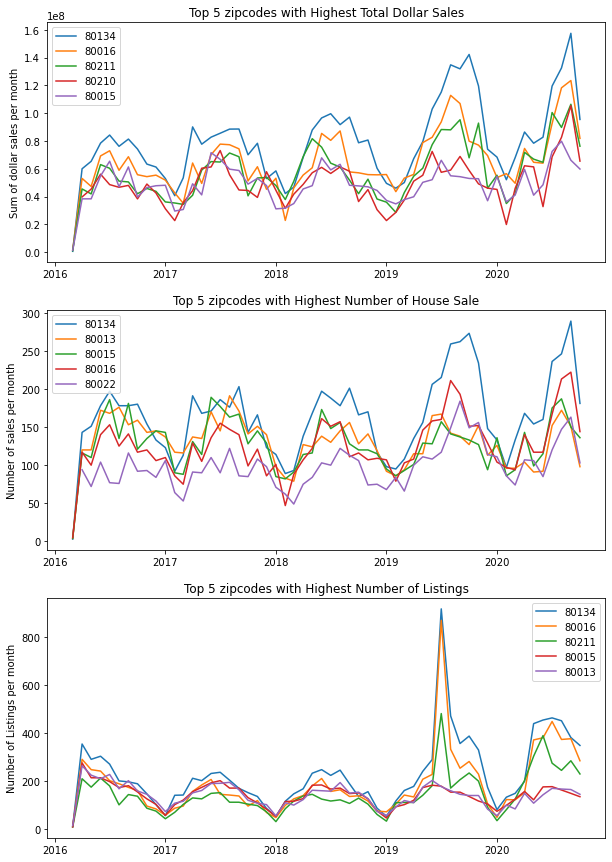

In [645]:
# Unnormalized metric - all values are raw values
fig, ax = plt.subplots(3,1,figsize=(10,15))
for zipcode in top10sales[:5]:
    df_plot = df_monthly[df_monthly["zipcode"]==zipcode]
    ax[0].plot(df_plot['month'], df_plot["total_value"], label=zipcode)
ax[0].legend()
ax[0].set_title("Top 5 zipcodes with Highest Total Dollar Sales")
ax[0].set_ylabel("Sum of dollar sales per month")

for zipcode in top10unitSold[:5]:
    df_plot = df_monthly[df_monthly["zipcode"]==zipcode]
    ax[1].plot(df_plot['month'], df_plot["count_sale"], label=zipcode)
ax[1].legend()
ax[1].set_title("Top 5 zipcodes with Highest Number of House Sale")
ax[1].set_ylabel("Number of sales per month")

for zipcode in top10listings[:5]:
    df_plot = df_monthly[df_monthly["zipcode"]==zipcode]
    ax[2].plot(df_plot['month'], df_plot["count_listing"], label=zipcode)
ax[2].legend()
ax[2].set_title("Top 5 zipcodes with Highest Number of Listings")
ax[2].set_ylabel("Number of Listings per month")

Text(0, 0.5, 'Number of Listings per month')

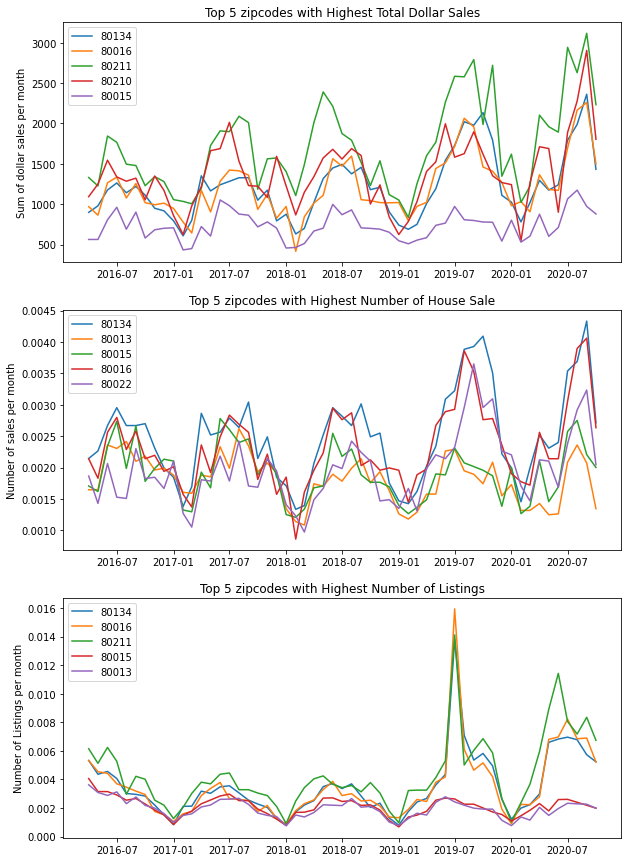

In [646]:
# Normalized metrics (per capita): values are divided by the population  

fig, ax = plt.subplots(3,1,figsize=(10,15))
for zipcode in top10sales[:5]:
    df_plot = df_monthly_population[df_monthly_population["zipcode"]==zipcode]
    ax[0].plot(df_plot['month'], df_plot["total_value_normalized"], label=zipcode)
ax[0].legend()
ax[0].set_title("Top 5 zipcodes with Highest Total Dollar Sales")
ax[0].set_ylabel("Sum of dollar sales per month")

for zipcode in top10unitSold[:5]:
    df_plot = df_monthly_population[df_monthly_population["zipcode"]==zipcode]
    ax[1].plot(df_plot['month'], df_plot["count_sale_normalized"], label=zipcode)
ax[1].legend()
ax[1].set_title("Top 5 zipcodes with Highest Number of House Sale")
ax[1].set_ylabel("Number of sales per month")

for zipcode in top10listings[:5]:
    df_plot = df_monthly_population[df_monthly_population["zipcode"]==zipcode]
    ax[2].plot(df_plot['month'], df_plot["count_listing_normalized"], label=zipcode)
ax[2].legend()
ax[2].set_title("Top 5 zipcodes with Highest Number of Listings")
ax[2].set_ylabel("Number of Listings per month")

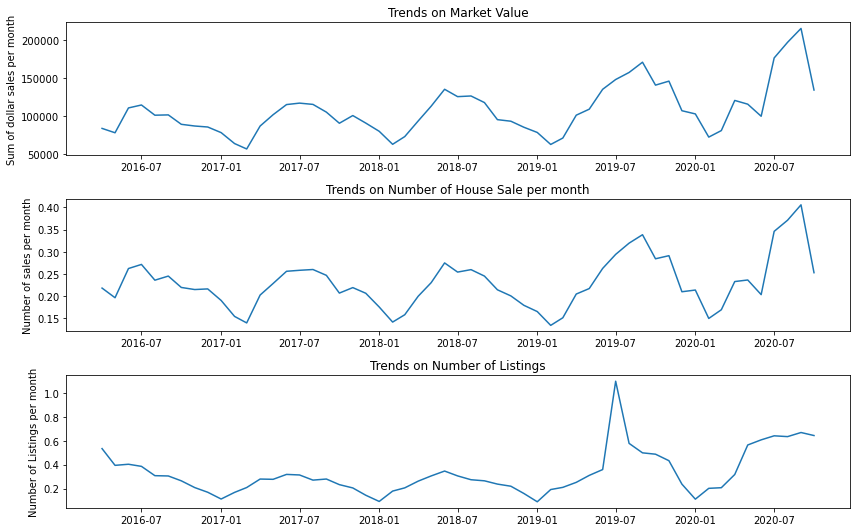

In [649]:
fig, ax = plt.subplots(3,1,figsize=(12,7.5))
df_plot = df_monthly_population.groupby("month").sum()[["total_value_normalized", "count_sale_normalized",
                                                        "count_listing_normalized"]].reset_index()
ax[0].plot(df_plot['month'], df_plot["total_value_normalized"], label="total_value")
ax[0].set_title("Trends on Market Value")
ax[0].set_ylabel("Sum of dollar sales per month")
ax[1].plot(df_plot['month'], df_plot["count_sale_normalized"], label="count_sale")
ax[1].set_title("Trends on Number of House Sale per month")
ax[1].set_ylabel("Number of sales per month")
ax[2].plot(df_plot['month'], df_plot["count_listing_normalized"], label="count_listings")
ax[2].set_title("Trends on Number of Listings")
ax[2].set_ylabel("Number of Listings per month")

plt.tight_layout()

In [391]:
df_monthly_population = df_monthly_population.sort_values('month')

### 1. Relationship with Google Trends Data (outdated - gtrends still from Boston's data)

In [375]:
# cd DigitalRealEstateIndex/google_trends
# keyword_to_time_series = np.load('googltrends.npy',allow_pickle='TRUE').item()
# plt.figure(figsize=(20, 10))
# for keyword, time_series in keyword_to_time_series.items():
#     plt.plot(time_series, label=keyword)
# plt.legend()
# plt.show()

In [376]:
# df_sale_agg = df_sale_monthly.groupby('sale_month').sum()[['count_sale', 'total_value']].reset_index()
# df_sale_googletrends = df_sale_agg.copy()
# n = len(df_sale_googletrends)
# for keyword, time_series in keyword_to_time_series.items():
#     df_sale_googletrends[keyword] = time_series[-n:]
    
# df_sale_googletrends["total_value_normalized"] = MinMaxScaler((0,100)).fit_transform(df_sale_googletrends.total_value.values.reshape(-1, 1))
# df_sale_googletrends["count_sale_normalized"] = MinMaxScaler((0,100)).fit_transform(df_sale_googletrends.count_sale.values.reshape(-1, 1))


# plt.figure(figsize=(15, 7))
# # plt.plot(df_sale_googletrends["total_value_normalized"], c="k", linewidth=2, label="total transaction value")
# plt.plot(df_sale_googletrends["count_sale_normalized"], c="black",  label="number of houses sold")
# for series in ['zillow', 'realtor.com', 'trulia', 'redfin']:
#     time_series = df_sale_googletrends[series]
#     plt.plot(time_series, label=series, linestyle=":")
# # plt.xticks(np.arange(len(time_series)),labels=df_sale_googletrends.sale_month.values, rotation=90)
# plt.legend()
# plt.title("Google Trends data for Massachusets", fontsize=16)



## Baseline Forecast per city, zipcode

### 1. Forecast for Market Value (Total Dollar Price of all Transaction)¶

In [401]:
model=pm.auto_arima(df_monthly_population[df_monthly_population["zipcode"]=='80134']["total_value_normalized"][:-n_periods],
                    seasonal=True, m=12)
pred, CI = model.predict(6, return_conf_int=True)

 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(3,0,0)(1,0,0)[12] intercept
 ARIMA(1,0,0)(0,1,1)[12] intercept
 ARIMA(1,0,0)(2,0,0)[12] intercept


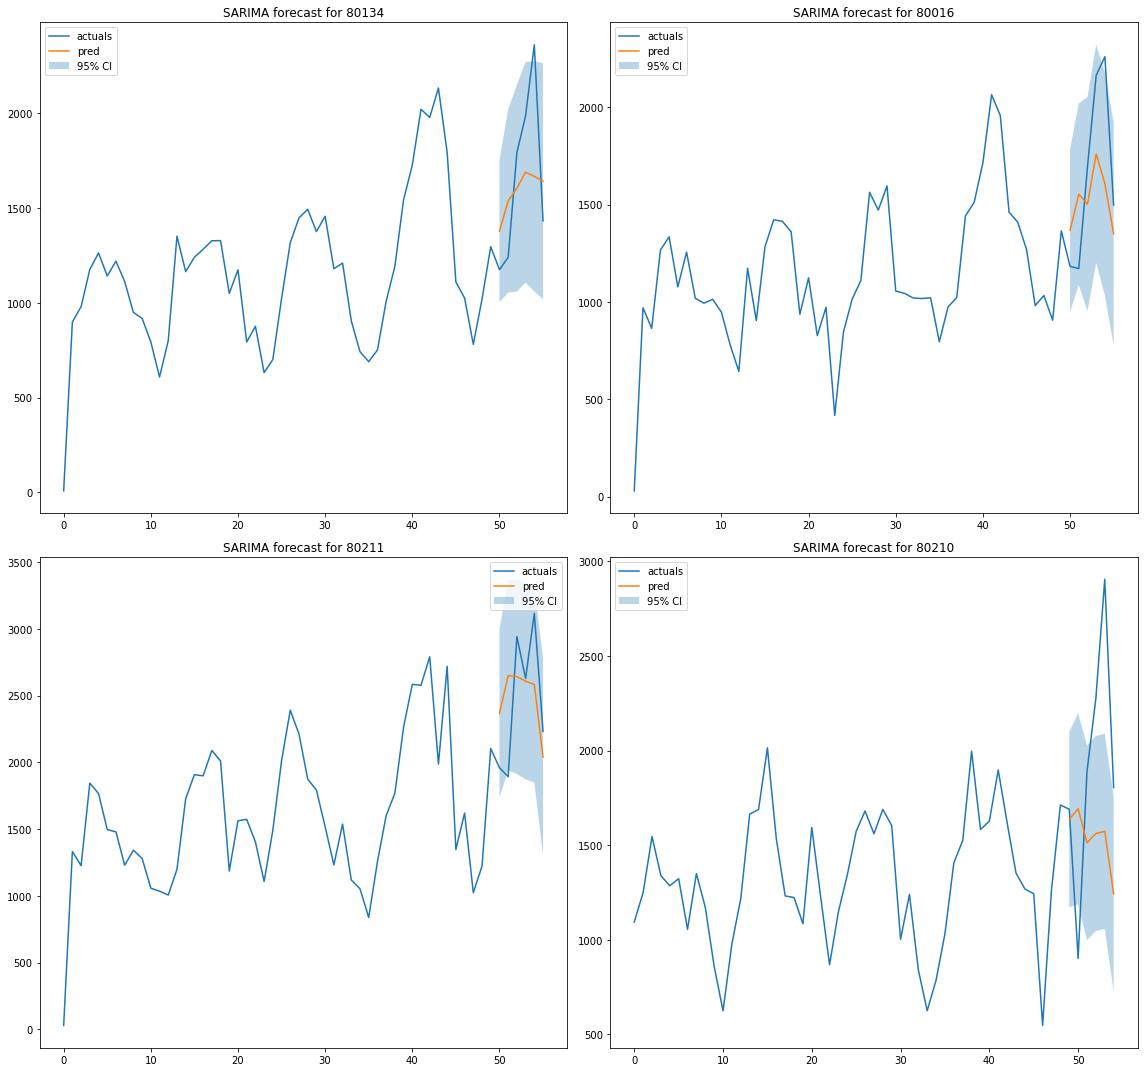

In [406]:
import matplotlib.dates as mdates
n_periods = 6
fig, ax = plt.subplots(2,2, figsize=(16,15))
for idx, area in enumerate(top10sales[:4]):
    model=pm.auto_arima(df_monthly_population[df_monthly_population["zipcode"]==area]["total_value_normalized"][:-n_periods], 
                        seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_monthly_population[df_monthly_population["zipcode"]==area]

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["total_value_normalized"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
#     ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
#     ax[idx//2, idx%2].set_xticklabels(df_plot["month"][::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
#     ax[idx//2, idx%2].format_xdata = mdates.DateFormatter('%Y-%m')
    
plt.tight_layout()
    

### 2. Forecast for Number of Units Sold¶

 ARIMA(1,0,0)(0,1,0)[12] intercept
 ARIMA(0,0,1)(2,0,1)[12] intercept
 ARIMA(0,0,1)(0,0,2)[12] intercept
 ARIMA(1,0,1)(1,0,0)[12] intercept


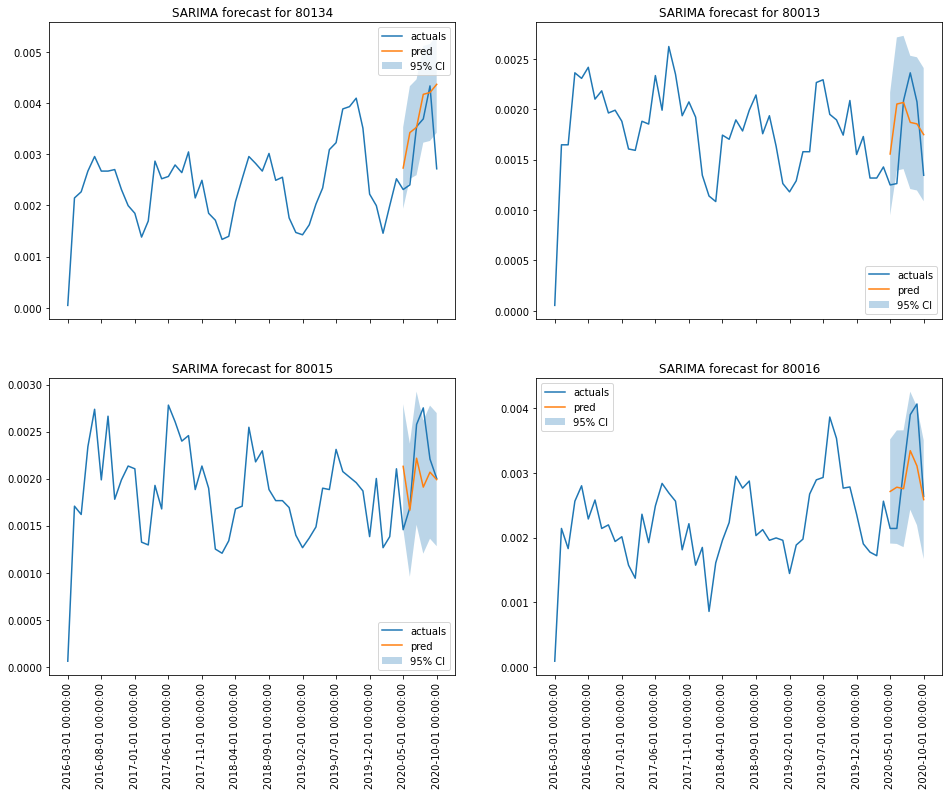

In [410]:
n_periods = 6
fig, ax = plt.subplots(2,2,sharex=True, figsize=(16,12))
for idx, area in enumerate(top10unitSold[:4]):
    model=pm.auto_arima(df_monthly_population[df_monthly_population["zipcode"]==area]["count_sale_normalized"][:-n_periods], 
                  seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_monthly_population[df_monthly_population["zipcode"]==area].sort_values("month")

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["count_sale_normalized"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
    ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
    ax[idx//2, idx%2].set_xticklabels(df_plot["month"][::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
    

In [571]:
# drop the data for the first month, which seems problematic
df_monthly_population = df_monthly_population[df_monthly_population.month > '2016-03-01']

## Forecasting with Bayesian Structural Time Series

In [418]:
# code snippets credits to MarkDaoust:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast


    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(dates,
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig=plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
        fig.tight_layout()
    return fig, ax

### Build Model - LocalLinearTrend


We'll model this series with a local linear trend, plus a month-of-year seasonal effect.

We first try to model this time series data by the simplest bayesian structural time series model, which includes a **local linear trend** and **seasonal effect**.
The idea is that the local linear trend will capture and increasing or decresing trend that's happening in the market, while the seasonal effect will capture any fluctuations that happens yearly (e.g. market is relatively slower at the begininng of the year, and then peak up at the middle of the year, and slowing down again at the end of the year)

The model would be formulated as below:
$$y_t = \mu_t + \tau_t + \epsilon_t$$
$$\mu_{t+1} = \mu_t + \delta_t + \eta_{0t}$$
$$\delta_{t+1} = \delta_t + \eta_{1t}$$
$$\tau_{t+1} = -\sum_{s = 1}^{S-1}\tau_{t} + \eta_{2t}.$$

In this model, $y_t$ is our time series data. $\mu_t$ captures the latent long-term trend, and the value at each time point will depend on the previous state. There is an additional term $\delta_t$ which basically the amount of extra $\mu$ we can expect as  $t \rightarrow t+1$ , so it can be interpreted as the slope of the local linear trend. The slope evolves according to a random walk, which makes the trend an integrated random walk with an extra drift term.

$\tau_t$ captures the seasonal effect. We can specify $S=12$ to indicate we have monthly data with yearly seasonal effect. The noises/variances is compromised by $\epsilon_t \sim N(0, \sigma^2)$ and $\eta_t \sim N(0,  \tau^2)$
This local level model is basically a random walk observed in noise, plus seasonal effect.


In [575]:
ts_denver = df_monthly_population.groupby('month').sum()['total_value_normalized'].values
ts_denver_countsale = df_monthly_population.groupby('month').sum()['count_sale_normalized'].values

ts_dates = np.arange("2016-04", "2020-11", dtype="datetime64[M]")
num_forecast_steps = 6 # Forecast the 6 months, given previous data


In [602]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

### Model Fitting 

We'll fit the model using variational inference. This involves running an optimizer to minimize a variational loss function, the negative evidence lower bound (ELBO). This fits a set of approximate posterior distributions for the parameters (in practice we assume these to be independent Normals transformed to the support space of each parameter).

The `tfp.sts` forecasting methods require posterior samples as inputs, so we'll finish by drawing a set of samples from the variational posterior.

In [506]:
def build_variational_posteriors(denver_model, denver_training_data, 
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True, nsamples=50
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=denver_model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=denver_model.joint_log_prob(observed_time_series=denver_training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples_denver = variational_posteriors.sample(nsamples)
    
    return q_samples_denver

In [499]:
# print("Inferred parameters:")
# for param in denver_model.parameters:
#     print("{}: {} +- {}".format(param.name,
#                                 np.mean(q_samples_denver[param.name], axis=0),
#                                 np.std(q_samples_denver[param.name], axis=0)))

In [610]:
# forecasting
def draw_forecast(ts_denver, denver_model, denver_training_data, q_samples_denver, num_forecast_steps, 
                  ts_dates = ts_dates, area='Denver', metric='Total dollar sales', num_samples=50, return_fig=False):
    denver_forecast_dist = tfp.sts.forecast(denver_model, observed_time_series=denver_training_data,
                                            parameter_samples=q_samples_denver, num_steps_forecast=num_forecast_steps)

    denver_forecast_mean, denver_forecast_scale, denver_forecast_samples = (denver_forecast_dist.mean().numpy()[..., 0],
                                                                            denver_forecast_dist.stddev().numpy()[..., 0],
                                                                            denver_forecast_dist.sample(num_samples).numpy()[..., 0])

    fig, ax = plot_forecast(ts_dates, ts_denver, denver_forecast_mean, denver_forecast_scale, denver_forecast_samples,
                            # x_locator=ts_loc, x_formatter=ts_fmt, 
                            title = metric+" Forecast for "+area)
    ax.axvline(ts_dates[-num_forecast_steps], linestyle="--")
    ax.legend(loc="upper left")
    ax.set_ylabel(metric)
    ax.set_xlabel("date")
    fig.autofmt_xdate()
    
    if return_fig:
        return denver_forecast_mean, denver_forecast_scale, denver_forecast_samples, fig, ax
    else:
        plt.show()
        return denver_forecast_mean, denver_forecast_scale, denver_forecast_samples

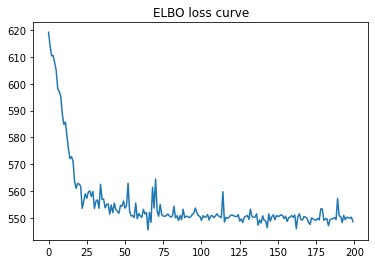

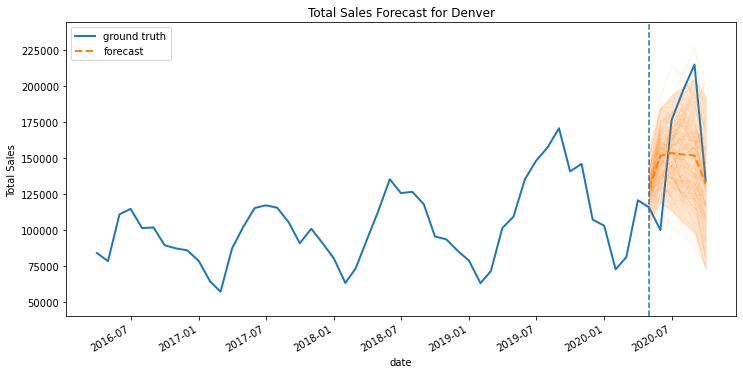

MSE for model1 - Total Sales: 1.558e+09


In [603]:
denver_training_data = ts_denver[:-num_forecast_steps]
denver_model = build_model(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Total Sales', 
                                                                                   num_samples=100)
print(f"MSE for model1 - Total Sales: {mean_squared_error(ts_denver[-num_forecast_steps:],denver_forecast_mean):.3e}")

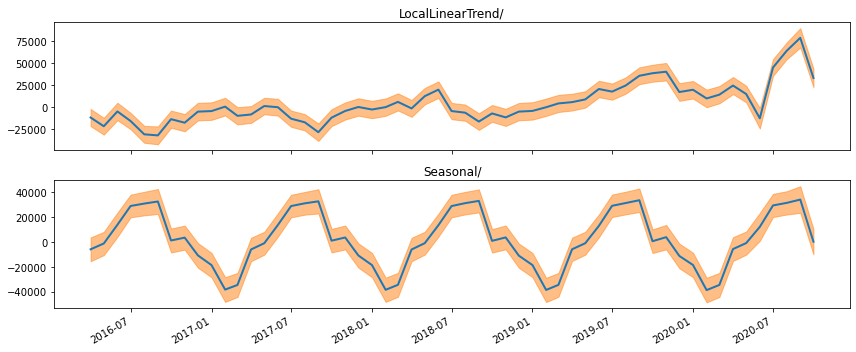

In [604]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver, parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


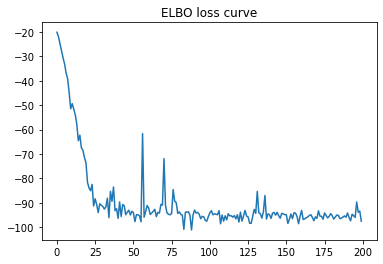

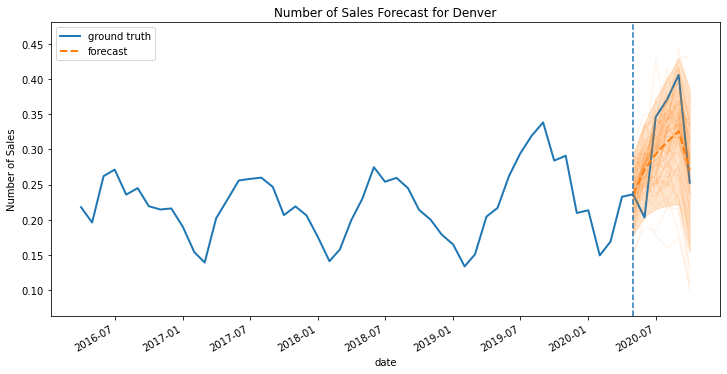

MSE for model1 - Count sale: 2.973e-03


In [605]:
denver_training_data = ts_denver_countsale[:-num_forecast_steps]

denver_model = build_model(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countsale, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Sales', 
                                                                                   num_samples=100)
print(f"MSE for model1 - Count sale: {mean_squared_error(ts_denver_countsale[-num_forecast_steps:],denver_forecast_mean):.3e}")


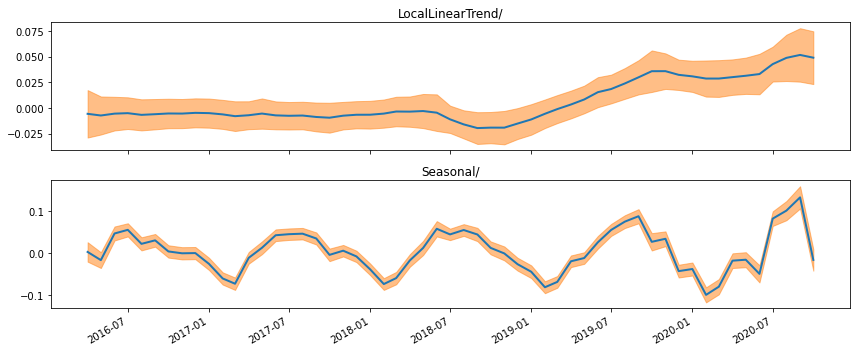

In [606]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countsale, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


### Model 2: Using SemiLocalLinearTrend


In SemiLocalLinearTrend, we have the same exact equation as above, except for the slope. We replace the random walk on the slope with a stationary AR(1) process, while keeping the random walk for the level of the process. 
$$\delta_{t+1} = D + \rho (\delta_t - D) + \eta_{1t}$$
The $D$ parameter is the long run slope of the trend component, to which $\delta_t$  will eventually revert. However  $\delta_t$  can have short term autoregressive deviations from the long term trend, with memory determined by $\rho $. Values of  $\rho$  close to 1 will lead to long deviations from $D$ .

The Final Formulation of the model is below:

The model would be formulated as below:
$$y_t = \mu_t + \tau_t + \epsilon_t$$
$$\mu_{t+1} = \mu_t + \delta_t + \eta_{0t}$$
$$\delta_{t+1} = D + \rho (\delta_t - D) + \eta_{1t}$$
$$\tau_{t+1} = -\sum_{s = 1}^{S-1}\tau_{t} + \eta_{2t}.$$


In [629]:
def build_model2(observed_time_series):
    trend = sts.SemiLocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

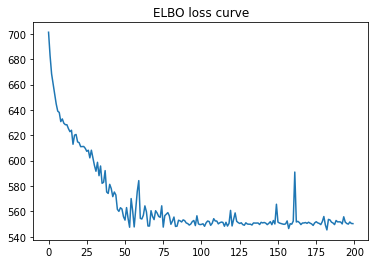

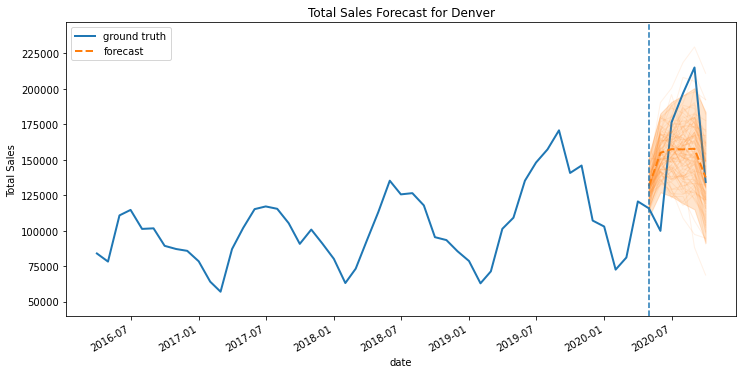

MSE for model3 - Total Sales: 1.415e+09


In [640]:
denver_training_data = ts_denver[:-num_forecast_steps]
denver_model = build_model2(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Total Sales', 
                                                                                   num_samples=100)
print(f"MSE for model3 - Total Sales: {mean_squared_error(ts_denver[-num_forecast_steps:],denver_forecast_mean):.3e}")


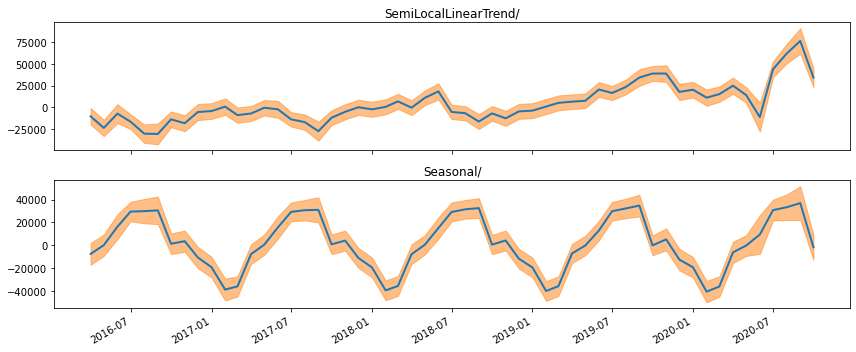

In [641]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


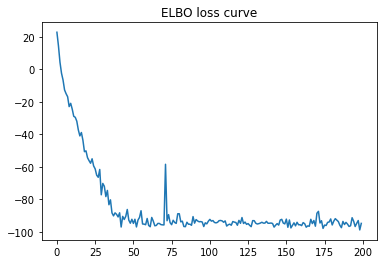

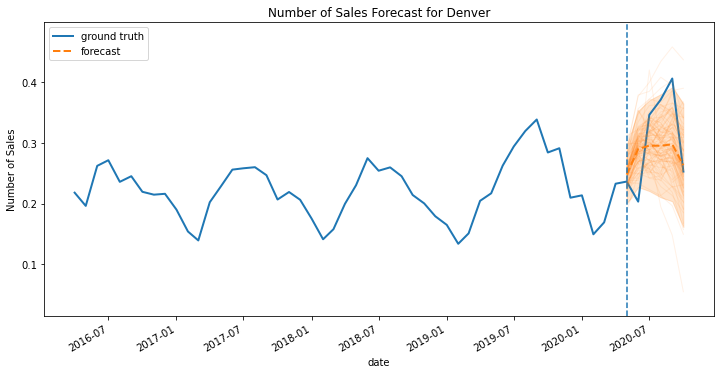

MSE for model3 - Count Sale: 4.640e-03


In [642]:
denver_training_data = ts_denver_countsale[:-num_forecast_steps]

denver_model = build_model2(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countsale, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Sales', 
                                                                                   num_samples=100)
print(f"MSE for model3 - Count Sale: {mean_squared_error(ts_denver_countsale[-num_forecast_steps:],denver_forecast_mean):.3e}")


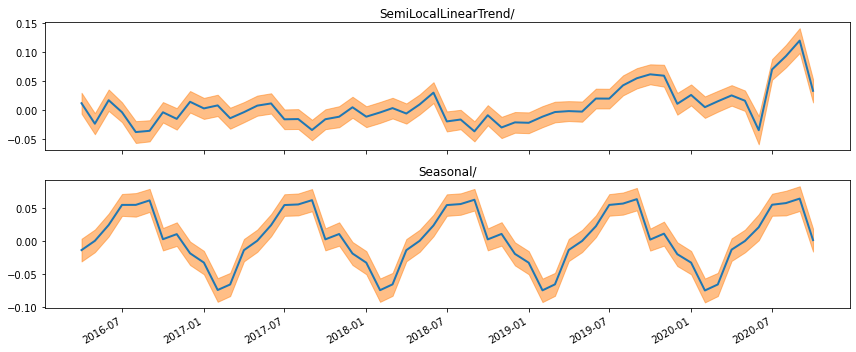

In [634]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countsale, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


### Forecast per zipcode

In [637]:
def forecast_bsts(df, metric, zipcode, ts_dates = np.arange("2016-04", "2020-11", dtype="datetime64[M]"), 
                  num_forecast_steps = 6, model = build_model2, ):
    ts_denver = df_monthly_population[df_monthly_population["zipcode"]==zipcode][metric].values
    denver_training_data = ts_denver[:-num_forecast_steps]
    denver_model = model(denver_training_data)
    q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                    optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                    plot = False, nsamples=50)
    
    if metric.find("count_sale") >=0: title = "Number of Sales"
    elif metric.find("total_value")>=0: title = "Total Dollar Sales"
    else: title=metric
        
    forecast_mean, forecast_scale, forecast_samples = draw_forecast(ts_denver, denver_model, denver_training_data,
                                                                    q_samples_denver, num_forecast_steps,
                                                                    ts_dates = ts_dates,
                                                                    area=zipcode, metric=title, 
                                                                    num_samples=100)
#     print(f"MSE for {zipcode} - Count Sale: {mean_squared_error(ts_denver[-num_forecast_steps:],forecast_mean):.3e}")
    return forecast_mean
    

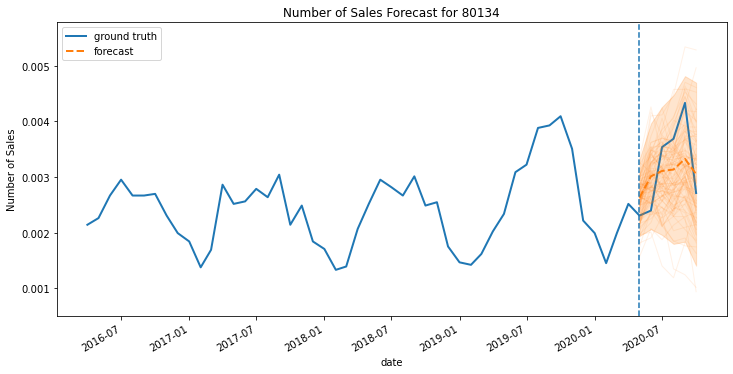

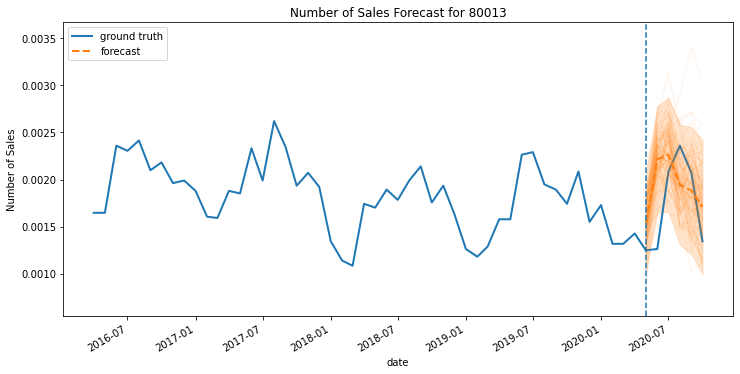

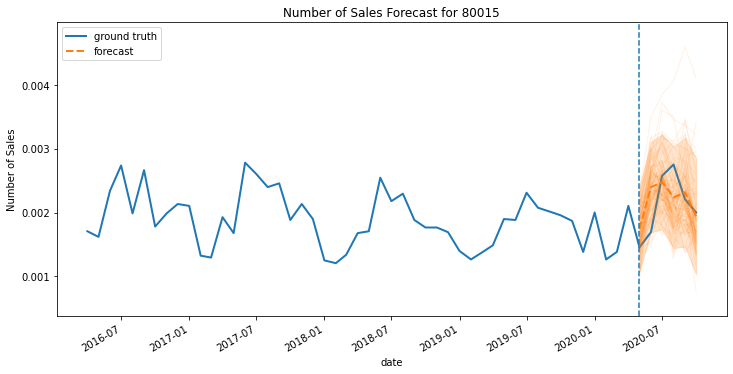

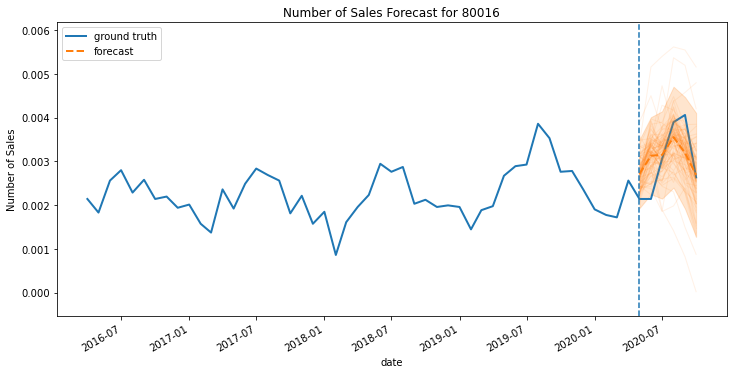

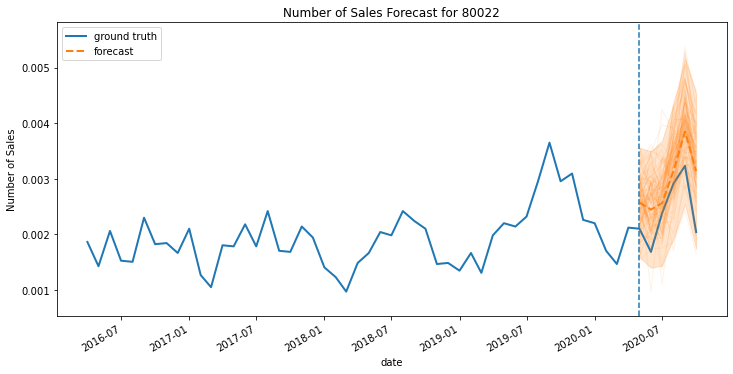

In [644]:
forecast_countsale_zipcode = {}
for idx, area in enumerate(top10unitSold[:5]):
    forecast_countsale_zipcode[area] = forecast_bsts(df_monthly_population, 'count_sale_normalized', area, 
                                                     model=build_model)

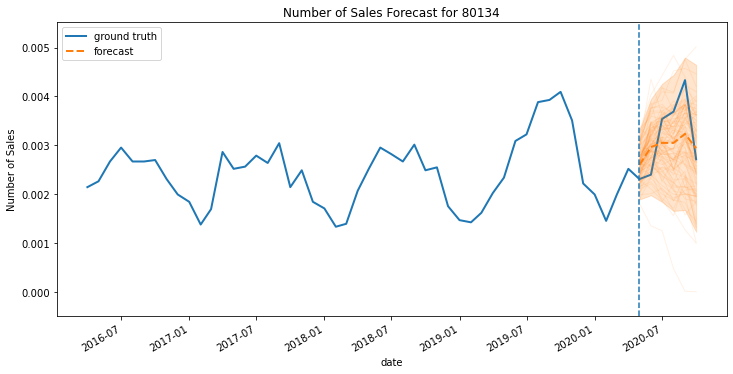

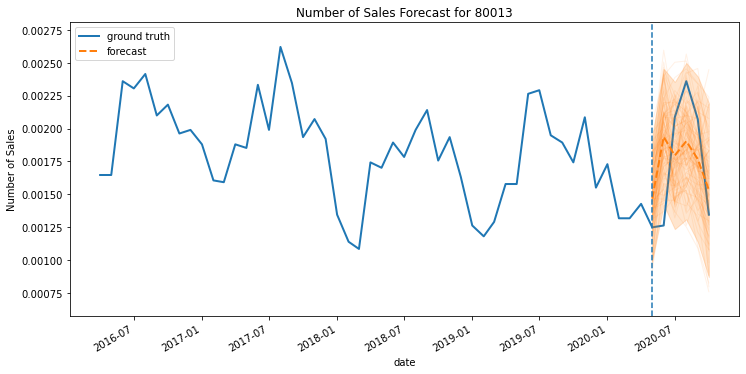

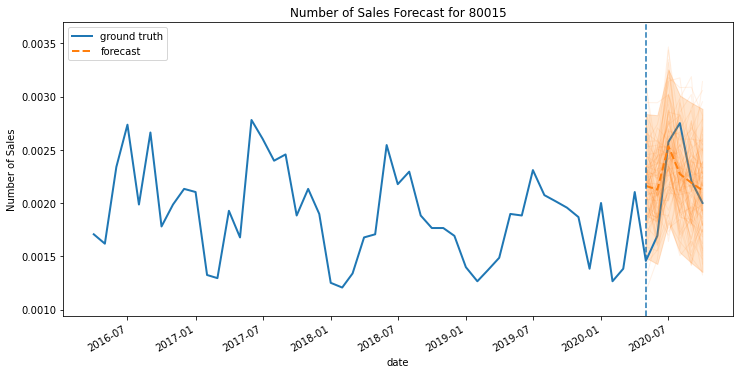

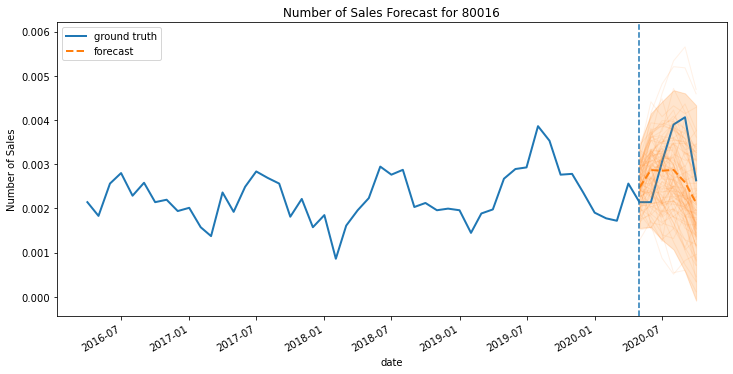

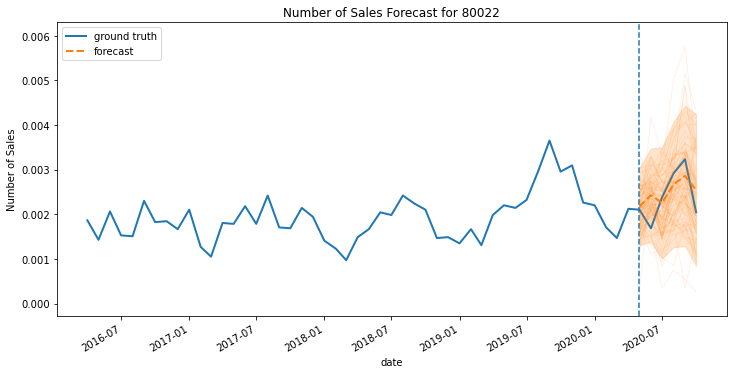

In [635]:
forecast_countsale_zipcode = {}
for idx, area in enumerate(top10unitSold[:5]):
    forecast_countsale_zipcode[area] = forecast_bsts(df_monthly_population, 'count_sale_normalized', area, 
                                                     model=build_model2)

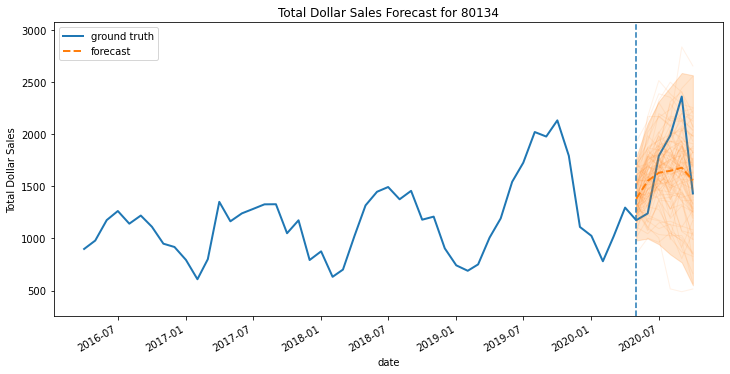

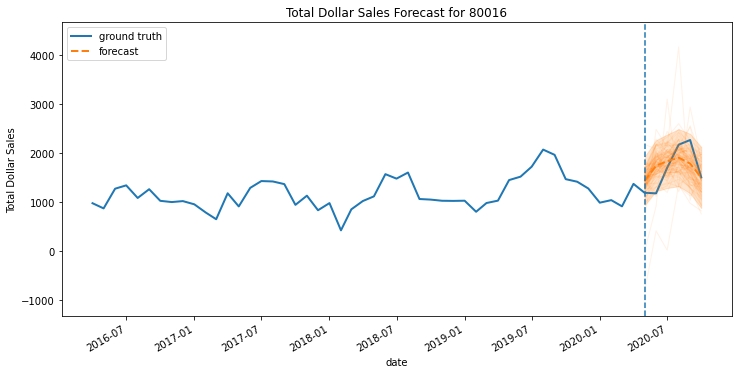

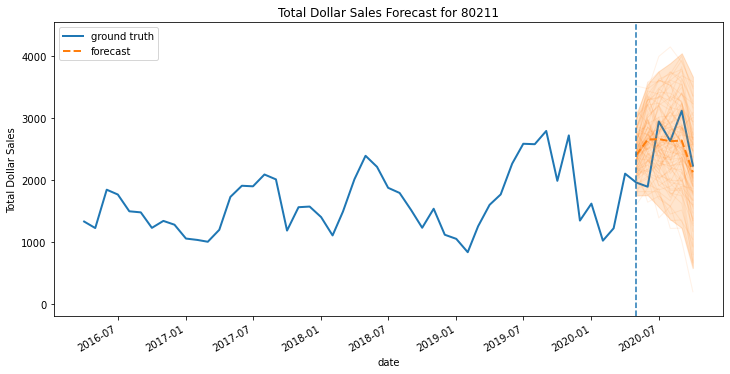

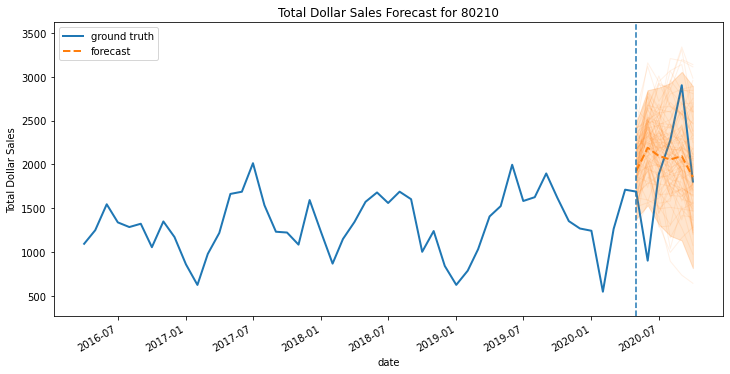

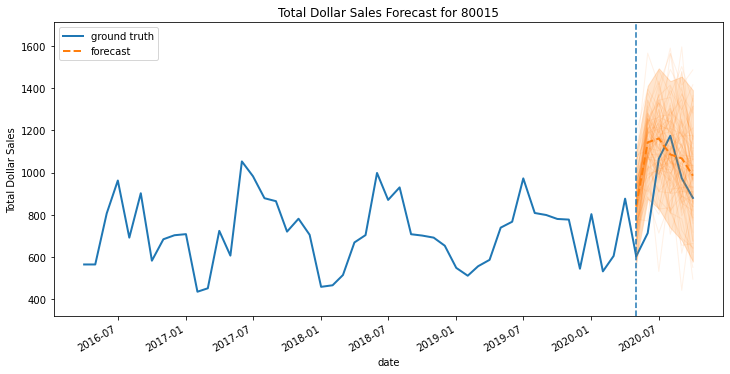

In [636]:
forecast_totalvalue_zipcode = {}
for idx, area in enumerate(top10sales[:5]):
    forecast_totalvalue_zipcode[area] = forecast_bsts(df_monthly_population, 'total_value_normalized', area, 
                                                      model=build_model2)